In [82]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.linalg import null_space

In [83]:
def get_matches(src, dst):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(src,None)
    kp2, des2 = sift.detectAndCompute(dst,None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    return src_pts, dst_pts

In [84]:
img1 = cv2.imread('test_images/messL.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('test_images/messR.png',cv2.IMREAD_GRAYSCALE)
height, width = img1.shape

In [320]:
def get_F(img1,img2):
    pts1, pts2 = get_matches(img1, img2)
    print(pts1[0])
    
    pts1 = pts1 - np.array([int(img1.shape[0]/2) , int(img1.shape[1]/2) ] )
    pts2 = pts2 - np.array([int(img2.shape[0]/2) , int(img2.shape[1]/2) ] )
    print(pts1[0])
    
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(pts1,pts2, cv2.FM_7POINT)
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    return pts1, pts2, F, mask

In [321]:
pts1, pts2, F, mask = get_F(img1,img2)




[[  3.096893 226.82224 ]]
[[-356.90310693 -413.17776489]]


In [304]:
def plot_(img1,img2,pts1,pts2, F):
    def drawlines(img1,img2,lines,pts1,pts2):
        ''' img1 - image on which we draw the epilines for the points in img2
            lines - corresponding epilines '''
        r,c = img1.shape
        img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
        img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
        for r,pt1,pt2 in zip(lines,pts1,pts2):
            color = tuple(np.random.randint(0,255,3).tolist())
            x0,y0 = map(int, [0, -r[2]/r[1] ])
            x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
            img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
            img1 = cv2.circle(img1,tuple(pt1.ravel().astype(np.int64)),5,color,-1)
            img2 = cv2.circle(img2,tuple(pt2.ravel().astype(np.int64)),5,color,-1)
        return img1,img2
    
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5, img6 = drawlines(img1,img2,lines1,pts1,pts2)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.figure(figsize=(30,30))
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()
    return img5, img3

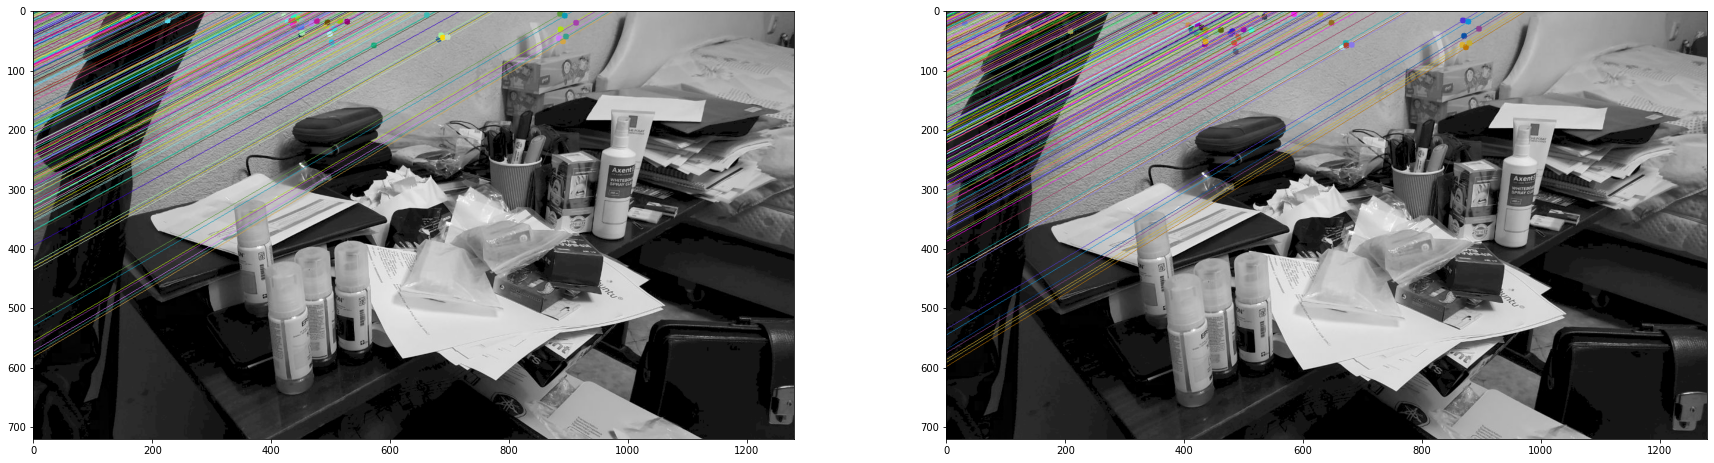

In [305]:
img5, img3 = plot_(img1,img2,pts1,pts2,F)

In [306]:
h1, w1 = img1.shape
h2, w2 = img2.shape
thresh = 0
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1), threshold=thresh,
)

tr_matrix = np.array([ [1, 0, -width/2],
                       [0, 1, -height/2],
                       [0, 0, 1]
                     ])
#(H1@np.array([0,0,1]))[0]

rec_img1_cv = cv2.warpPerspective(img5, H1, (1*w1, 1*h1))
rec_img2_cv = cv2.warpPerspective(img3, H2, (1*w2, 1*h2))

In [307]:
H1

array([[-6.89580698e-02,  4.52414896e-02, -3.20968894e+01],
       [-4.50463192e-02, -8.60935549e-02,  2.44060097e+01],
       [ 1.95596613e-05, -1.31936560e-05, -1.05084743e-01]])

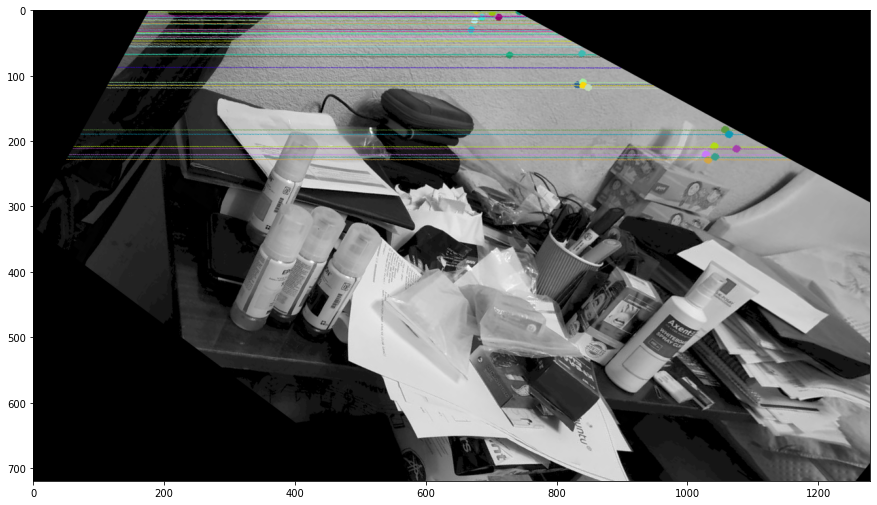

In [308]:
plt.figure(figsize=(15,15))
plt.imshow(rec_img1_cv,cmap='gray')

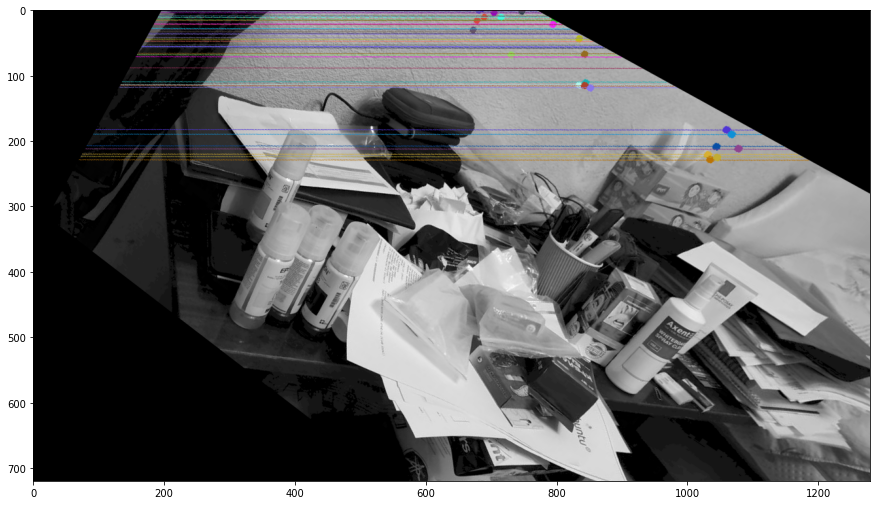

In [309]:
plt.figure(figsize=(15,15))
plt.imshow(rec_img2_cv,cmap='gray')

In [310]:
#pts1_opencv, pts2_opencv, F_opencv, mask_opencv = get_F(rec_img1_cv,rec_img2_cv)

In [311]:
#plot_(rec_img1_cv,rec_img2_cv,pts1_opencv,pts2_opencv,F_opencv)

In [312]:
def rectify_uncalibrated(pts1, pts2, F):
    k = np.array([0,0,1])
    er = null_space(F.T).ravel()
    er = er/er[-1]
    # homography for right image
    Rr = np.zeros((3,3))
    Rr[0,:] = np.cross(k,np.cross(er,k))/np.linalg.norm(np.cross(k,np.cross(er,k)))
    Rr[1,:] = np.cross(k,er)/np.linalg.norm(np.cross(k,er))
    Rr[2,:] = k - np.cross(k,np.cross(er,k))/(np.cross(k,np.cross(er,k))@er)
    # homography for left image
    Rl_prime = np.zeros((3,3))
    Rl_prime[2,:] = np.cross(k,er)@F*(   1 + 1/(  np.cross(k,np.cross(er,k))@er  )     )
    Rl_prime[1,:] = (np.cross(np.cross(k,er),er)@F)/np.linalg.norm(np.cross(k,np.cross(er,k)))
    Rl_prime[0,:] = np.cross(Rl_prime[1,:], Rl_prime[2,:])
    # add ones for 3d-transformation
    pts1_with_ones = np.dstack((pts1,  np.ones((pts1.shape[0],1)))).reshape(-1,3,1)
    pts2_with_ones = np.dstack((pts2,  np.ones((pts2.shape[0],1)))).reshape(-1,3,1)
    # form linear equation system
    right_part = np.matmul(Rr,pts2_with_ones).reshape(-1,3)
    right_part = right_part[:,0]/right_part[:,2]

    left_part = np.matmul(Rl_prime,pts1_with_ones).reshape(-1,3)
    left_part = left_part/ left_part[:,2,np.newaxis]

    right_part = np.matmul(Rr,pts2_with_ones).reshape(-1,3)
    right_part = right_part[:,0]/right_part[:,2]

    left_part = np.matmul(Rl_prime,pts1_with_ones).reshape(-1,3)
    left_part = left_part/ left_part[:,2,np.newaxis]
    # solve using linear regression
    a,b,c  = np.linalg.lstsq(left_part,right_part,rcond = None)[0]

    Rl = np.array([[a,b,c],
               [0,1,0],
               [0,0,1]])@Rl_prime
    Rl = Rl/Rl[-1,-1]
    
    return Rr, Rl
    

In [313]:
def warp_rectified(img1, img2, Rr, Rl):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    rec_img1 = cv2.warpPerspective(img1, Rl,(1*w1, 1*h1))
    rec_img2 = cv2.warpPerspective(img2, Rr,(1*w2, 1*h2))


    plt.figure(figsize=(15,15))
    plt.imshow(rec_img1)

    plt.figure(figsize=(15,15))
    plt.imshow(rec_img2)
    
    return rec_img1, rec_img2

In [314]:
Rr, Rl = rectify_uncalibrated(pts1, pts2, F)

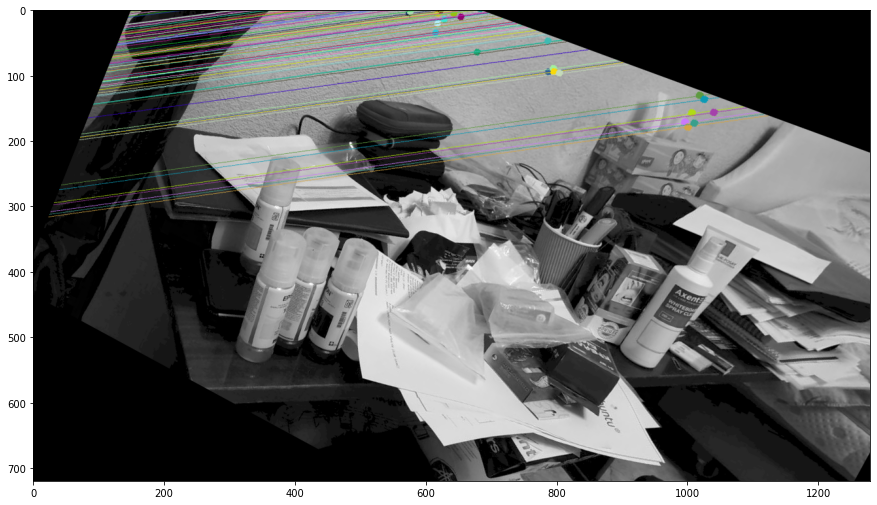

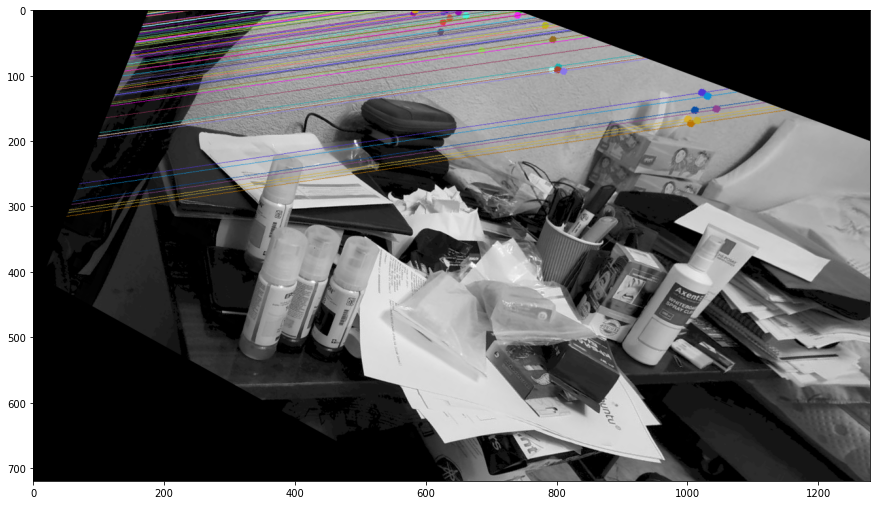

In [315]:
_, _ = warp_rectified(img5, img3, np.linalg.inv(tr_matrix)@Rr@tr_matrix, np.linalg.inv(tr_matrix)@Rl@tr_matrix)
#_, _ = warp_rectified(img5, img3, Rr, Rl)

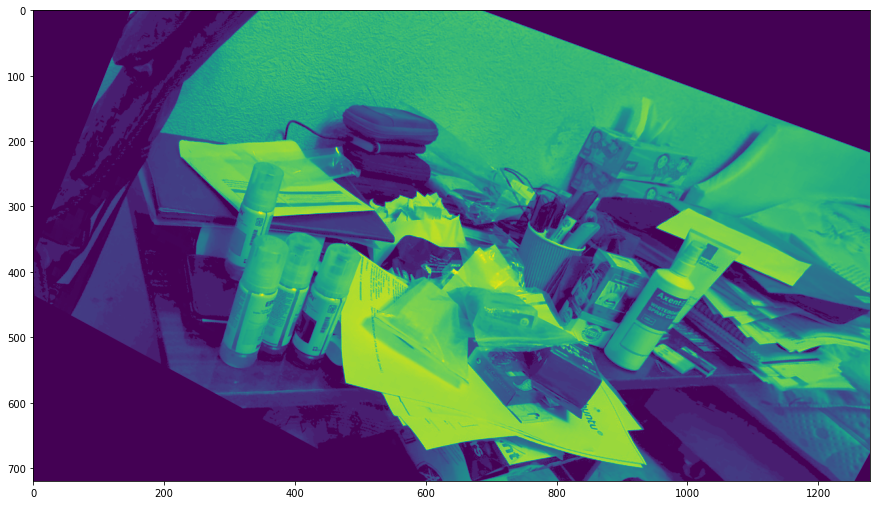

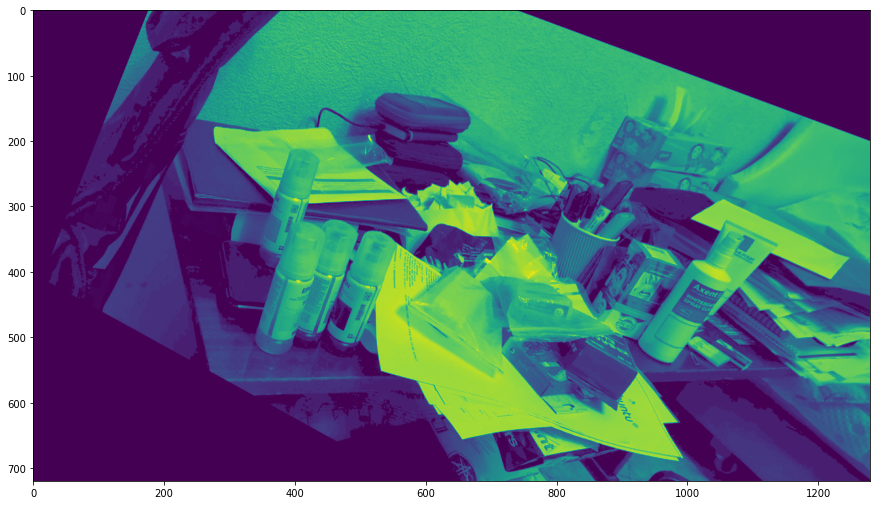

In [316]:
rectified1,rectified2 = warp_rectified(img2, img1, np.linalg.inv(tr_matrix)@Rr@tr_matrix, np.linalg.inv(tr_matrix)@Rl@tr_matrix)

In [317]:
cv2.imwrite("rectified1.png", rectified1)
cv2.imwrite("rectified2.png", rectified2)


True

In [194]:
np.array([])H1

SyntaxError: invalid syntax (<ipython-input-194-ab892ddc4f5d>, line 1)

In [195]:
-1/(H1*np,)

TypeError: unsupported operand type(s) for *: 'float' and 'module'

In [196]:
np.array([ [1,0,0],
          [0,1,0],
          [(H1@np.array([0,0,1]))[0], 0,1]
         ])
    
    
    

array([[  1.        ,   0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        ],
       [-23.34612608,   0.        ,   1.        ]])